In [4]:
using Glob  # find files with a specific pattern
using DelimitedFiles, DataFrames, EzXML #read txt  and xml and then convert them to DataFrames
using Dates
using LaTeXStrings
#using ContinuousWavelets  #wavelet power
using Interpolations # interpolation
#using StaticArrays #faster array
#using VMD # VMD decomposition
using DSP
using LinearAlgebra
using Wavelets
using FFTW
using Statistics
using CSV
include("../src/scripts/TCWavelet.jl")

chisquare_solve (generic function with 1 method)

In [95]:
date = DateTime(2022, 08, 24, 07, 40, 00)
shock_time = DateTime(2022, 08, 24, 07, 55, 20)
ds = 10

10

In [34]:
# read data
const Rm = 3390.0  #km 
datapath2c32hz = "E:/WorkSpace/Tianwen/Data/32Hz/"
# datapath2c32hz = "E:/WorkSpace/Tianwen/Data/1Hz/"
datestr = Dates.format.(date, "yyyymmdd")
file2c32hz = datapath2c32hz * "TW1_MOMAG_MSO_32Hz_" * datestr * "_2C_v03.dat"
# file2c32hz = datapath2c32hz * "TW1_MOMAG_MSO_01Hz_" * datestr * "_2C_v03.dat"
println("Reading file: ")
println(file2c32hz)
global mag2c32hz = identity.(DataFrame(readdlm(file2c32hz, skipstart=19), :auto))
name = ["Time", "Sampling_Rate", "X_MSO", "Y_MSO", "Z_MSO", "Probe_Position_X_MSO", "Probe_Position_Y_MSO", 
    "Probe_Position_Z_MSO", "Roll", "Pitch", "Yaw",  "Quality_Flags"]
rename!(mag2c32hz, name)
mag2c32hz[!, :Time] = map(x->DateTime(x[begin:end-4], DateFormat("y-m-dTH:M:S.s")), mag2c32hz[!, :Time])
mag2c32hz[!, :JulUT] = datetime2julian.(mag2c32hz[!, :Time])
unique!(mag2c32hz) #remove depulicate rows
sort!(mag2c32hz) #sorting
magut32hz = mag2c32hz[:, :JulUT].-mag2c32hz[1, :JulUT]
global BMSO32hz = mag2c32hz[:, [:X_MSO, :Y_MSO, :Z_MSO]]
ind0 = findall(x-> !isnan(x), BMSO32hz[!, 1] ) 
ind1 = findall(x-> isnan(x), BMSO32hz[!, 1] ) 
if length(ind1) >= 1 && length(ind0) > 1
    for ib in 1:3 
        interp_linear = linear_interpolation(magut32hz[ind0], BMSO32hz[ind0, ib]; extrapolation_bc=Line())
        BMSO32hz[ind1, ib] = interp_linear(magut32hz[ind1])
    end
end
mag2c32hz[!,[ :Probe_Position_X_MSO, :Probe_Position_Y_MSO, :Probe_Position_Z_MSO]] = 
    mag2c32hz[!,[ :Probe_Position_X_MSO, :Probe_Position_Y_MSO, :Probe_Position_Z_MSO]]./Rm
println("Data read finished!")

Reading file: 
E:/WorkSpace/Tianwen/Data/32Hz/TW1_MOMAG_MSO_32Hz_20220824_2C_v03.dat
Data read finished!


In [107]:
# 分离背景磁场和波动磁场
timeWave = date .+ Dates.Second(ds) .* range(0,6)
timeShock = shock_time - Dates.Minute(1) .+ Dates.Minute(1) .* range(0, 2)
timeSolar = shock_time .- Dates.Minute(1) .* range(0,5)
indWave = findall(
(minimum(timeWave) .<= mag2c32hz.Time .<= maximum(timeWave)) .&
.!isnan.(mag2c32hz.X_MSO) .&
.!isnan.(mag2c32hz.Y_MSO) .&
.!isnan.(mag2c32hz.Z_MSO)
)
intShock = findall(
(minimum(timeShock) .<= mag2c32hz.Time .<= maximum(timeShock)) .&
.!isnan.(mag2c32hz.X_MSO) .&
.!isnan.(mag2c32hz.Y_MSO) .&
.!isnan.(mag2c32hz.Z_MSO)
)
intSolar = findall(
(minimum(timeSolar) .<= mag2c32hz.Time .<= maximum(timeSolar)) .&
.!isnan.(mag2c32hz.X_MSO) .&
.!isnan.(mag2c32hz.Y_MSO) .&
.!isnan.(mag2c32hz.Z_MSO)
)
magWave = mag2c32hz[indWave, [:X_MSO, :Y_MSO, :Z_MSO]]
magShock = mag2c32hz[intShock, [:X_MSO, :Y_MSO, :Z_MSO]]
magSolar = mag2c32hz[intSolar, [:X_MSO, :Y_MSO, :Z_MSO]]
magWaveMean = zeros(1, 3)
magSolarMean = zeros(1, 3)
for i in 1:3
    magWaveMean[1, i] = mean(magWave[:, i])
    magSolarMean[1, i] = mean(magSolar[:, i])
end
magWave = magWave .- magWaveMean
println("Background field separated!")

Background field separated!


In [97]:
#FFT计算波动频率

# 计算单分量信号的功率谱密度（PSD）
function compute_psd(signal::Vector{Float64}, fs::Float64)
    n = length(signal)
    # 1. 去均值（消除直流分量）
    signal_centered = signal .- mean(signal)
    # 2. 加汉宁窗（减少频谱泄漏）
    window = hanning(n)
    signal_windowed = signal_centered .* window
    # 3. 计算FFT（实数信号，只需正频率部分）
    fft_result = rfft(signal_windowed)
    freqs = rfftfreq(n, fs)  # 正频率轴
    # 4. 计算功率谱密度（PSD）
    psd = abs2.(fft_result) ./ (fs * sum(window.^2))  # 归一化
    return (frequencies=freqs, psd=psd)
end

# 主函数：分析磁场波动的主频率（针对三分量）
function analyze_dominant_frequency(mag2c32hz::DataFrame, fs::Float64)
    
    mag_event = mag2c32hz[:, [:X_MSO, :Y_MSO, :Z_MSO]]
    
    # 为每个分量计算PSD和主频率
    dominant_freqs = Vector{Float64}(undef, 3)
    psd_results = Vector{Any}(undef, 3)
    
    for i in 1:3
        component = mag_event[:, i]
        freqs, psd = compute_psd(component, fs)
        
        max_idx = argmax(psd)
        dominant_freq = freqs[max_idx]
        dominant_freqs[i] = dominant_freq
        psd_results[i] = (frequencies=freqs, psd=psd)
        
    end
    
    return (
        maxFreq=dominant_freqs[argmax(dominant_freqs)],  # 最大主频率
        dominant=dominant_freqs,  # 各分量的主频率 [Bx, By, Bz]
        psd=psd_results          # 各分量的PSD数据（绘图用）
    )
end

fs = 32.0  
freq = analyze_dominant_frequency(magWave, fs)
temp = sqrt.(sum(Array(magWave).^2, dims=2))
freq_main,psd_main = compute_psd(temp[:], fs)
freq_main = freq_main[argmax(psd_main)]
@show freq_main
# 分量主频FrequenceXYZ
println("各分量主频率result_freq.dominant_freqs(Bx, By, Bz): ", freq.dominant, " Hz")

freq_main = 0.016666666666666666
各分量主频率result_freq.dominant_freqs(Bx, By, Bz): [1.3166666666666667, 1.4333333333333333, 1.4333333333333333] Hz


In [108]:
# 波动性质和激波性质
function MVA(magbc)
    nb = length(magbc[:, 1])
    bm = mean(magbc, dims=1)
    muv = magbc' * magbc ./ nb - bm' * bm
    return eigen(muv)
end

function xyz_to_new_basis(point::Matrix{Float64}, basis_vectors::AbstractVector{<:AbstractVector})::Matrix{Float64}
    basis_matrix = hcat(basis_vectors...)
    return (basis_matrix' * point')'
end

function angle_between(v1, v2)
    cosθ = dot(v1, v2) / (norm(v1) * norm(v2))
    return acosd(clamp(cosθ, -1.0, 1.0))  # 限制范围防止数值误差
end

# 波动性质
bWave = Array(magWave)
Bmean = Array(magWaveMean)
bm = MVA(bWave)
# 波矢量WaveNormal
kWave = bm.vectors[:, argmin(bm.values)]
Bmva = bWave*bm.vectors
Bmvamean= dropdims(mean(Bmva, dims=1), dims=1)
# 振幅Amplitude
Amplitude = sum(bm.values[1:3])

# 激波性质
bShock = Array(magShock[:, 1:3])
BmeanShock = dropdims(mean(bShock, dims=1), dims=1)
bmShock = MVA(bShock)
# 激波法向ShockNormal
kShock = bmShock.vectors[:, 1]
# 太阳风性质
bSolar = Array(magSolar[:, 1:3])
BmeanSolar = dropdims(mean(bSolar, dims=1), dims=1)
bmSolar = MVA(bSolar)
kSolar = bmSolar.vectors[:, 1]
# 传播角PropagationAngle
ProAngle = angle_between(kWave, magWaveMean)
ShockAngle = angle_between(magSolarMean, kShock)
# ShockAngle = angle_between(kSolar, kShock)
if ShockAngle>90
    ShockAngle = 180 -ShockAngle
end

magback = sqrt(sum(Bmean.^2))
maxAm = maximum([maximum(bWave[:,1])-minimum(bWave[:,1]), maximum(bWave[:,2])-minimum(bWave[:,2]), 
    maximum(bWave[:,3])-minimum(bWave[:,3])])

println("Amplitude: ", Amplitude)
println("Propagation Angle: ", ProAngle)
println("Shock Angle: ", ShockAngle)
println("Magnetic Background: ", magback)

Amplitude: 6.200073079519584
Propagation Angle: 46.58531364853817
Shock Angle: 83.3904918372485
Magnetic Background: 2.6228469531696375


In [123]:
bWave

1920×3 Matrix{Float64}:
  0.550795   -2.32046   -2.44545
  0.112795   -2.92046   -2.09045
 -0.380205   -3.40146   -1.71645
 -0.706205   -3.57046   -1.25945
 -1.0512     -3.52446   -0.584448
 -1.4792     -3.21346    0.263552
 -1.6992     -2.57046    0.878552
 -1.7832     -1.96746    1.35555
 -1.8482     -1.33346    1.76655
 -1.8052     -0.575462   2.03755
 -1.7112      0.204538   2.14355
 -1.4112      0.679538   1.96155
 -0.925205    0.958538   1.44655
  ⋮                     
  0.0437953  -0.171462  -0.400448
 -0.0952047  -0.177462  -0.399448
 -0.226205   -0.154462  -0.429448
 -0.241205   -0.178462  -0.390448
 -0.304205   -0.248462  -0.467448
 -0.358205   -0.241462  -0.505448
 -0.347205   -0.234462  -0.490448
 -0.373205   -0.264462  -0.439448
 -0.336205   -0.225462  -0.414448
 -0.320205   -0.237462  -0.371448
 -0.381205   -0.338462  -0.258448
 -0.351205   -0.276462  -0.168448

In [142]:
minimum(xtk)

0.316976f0

Drawing...


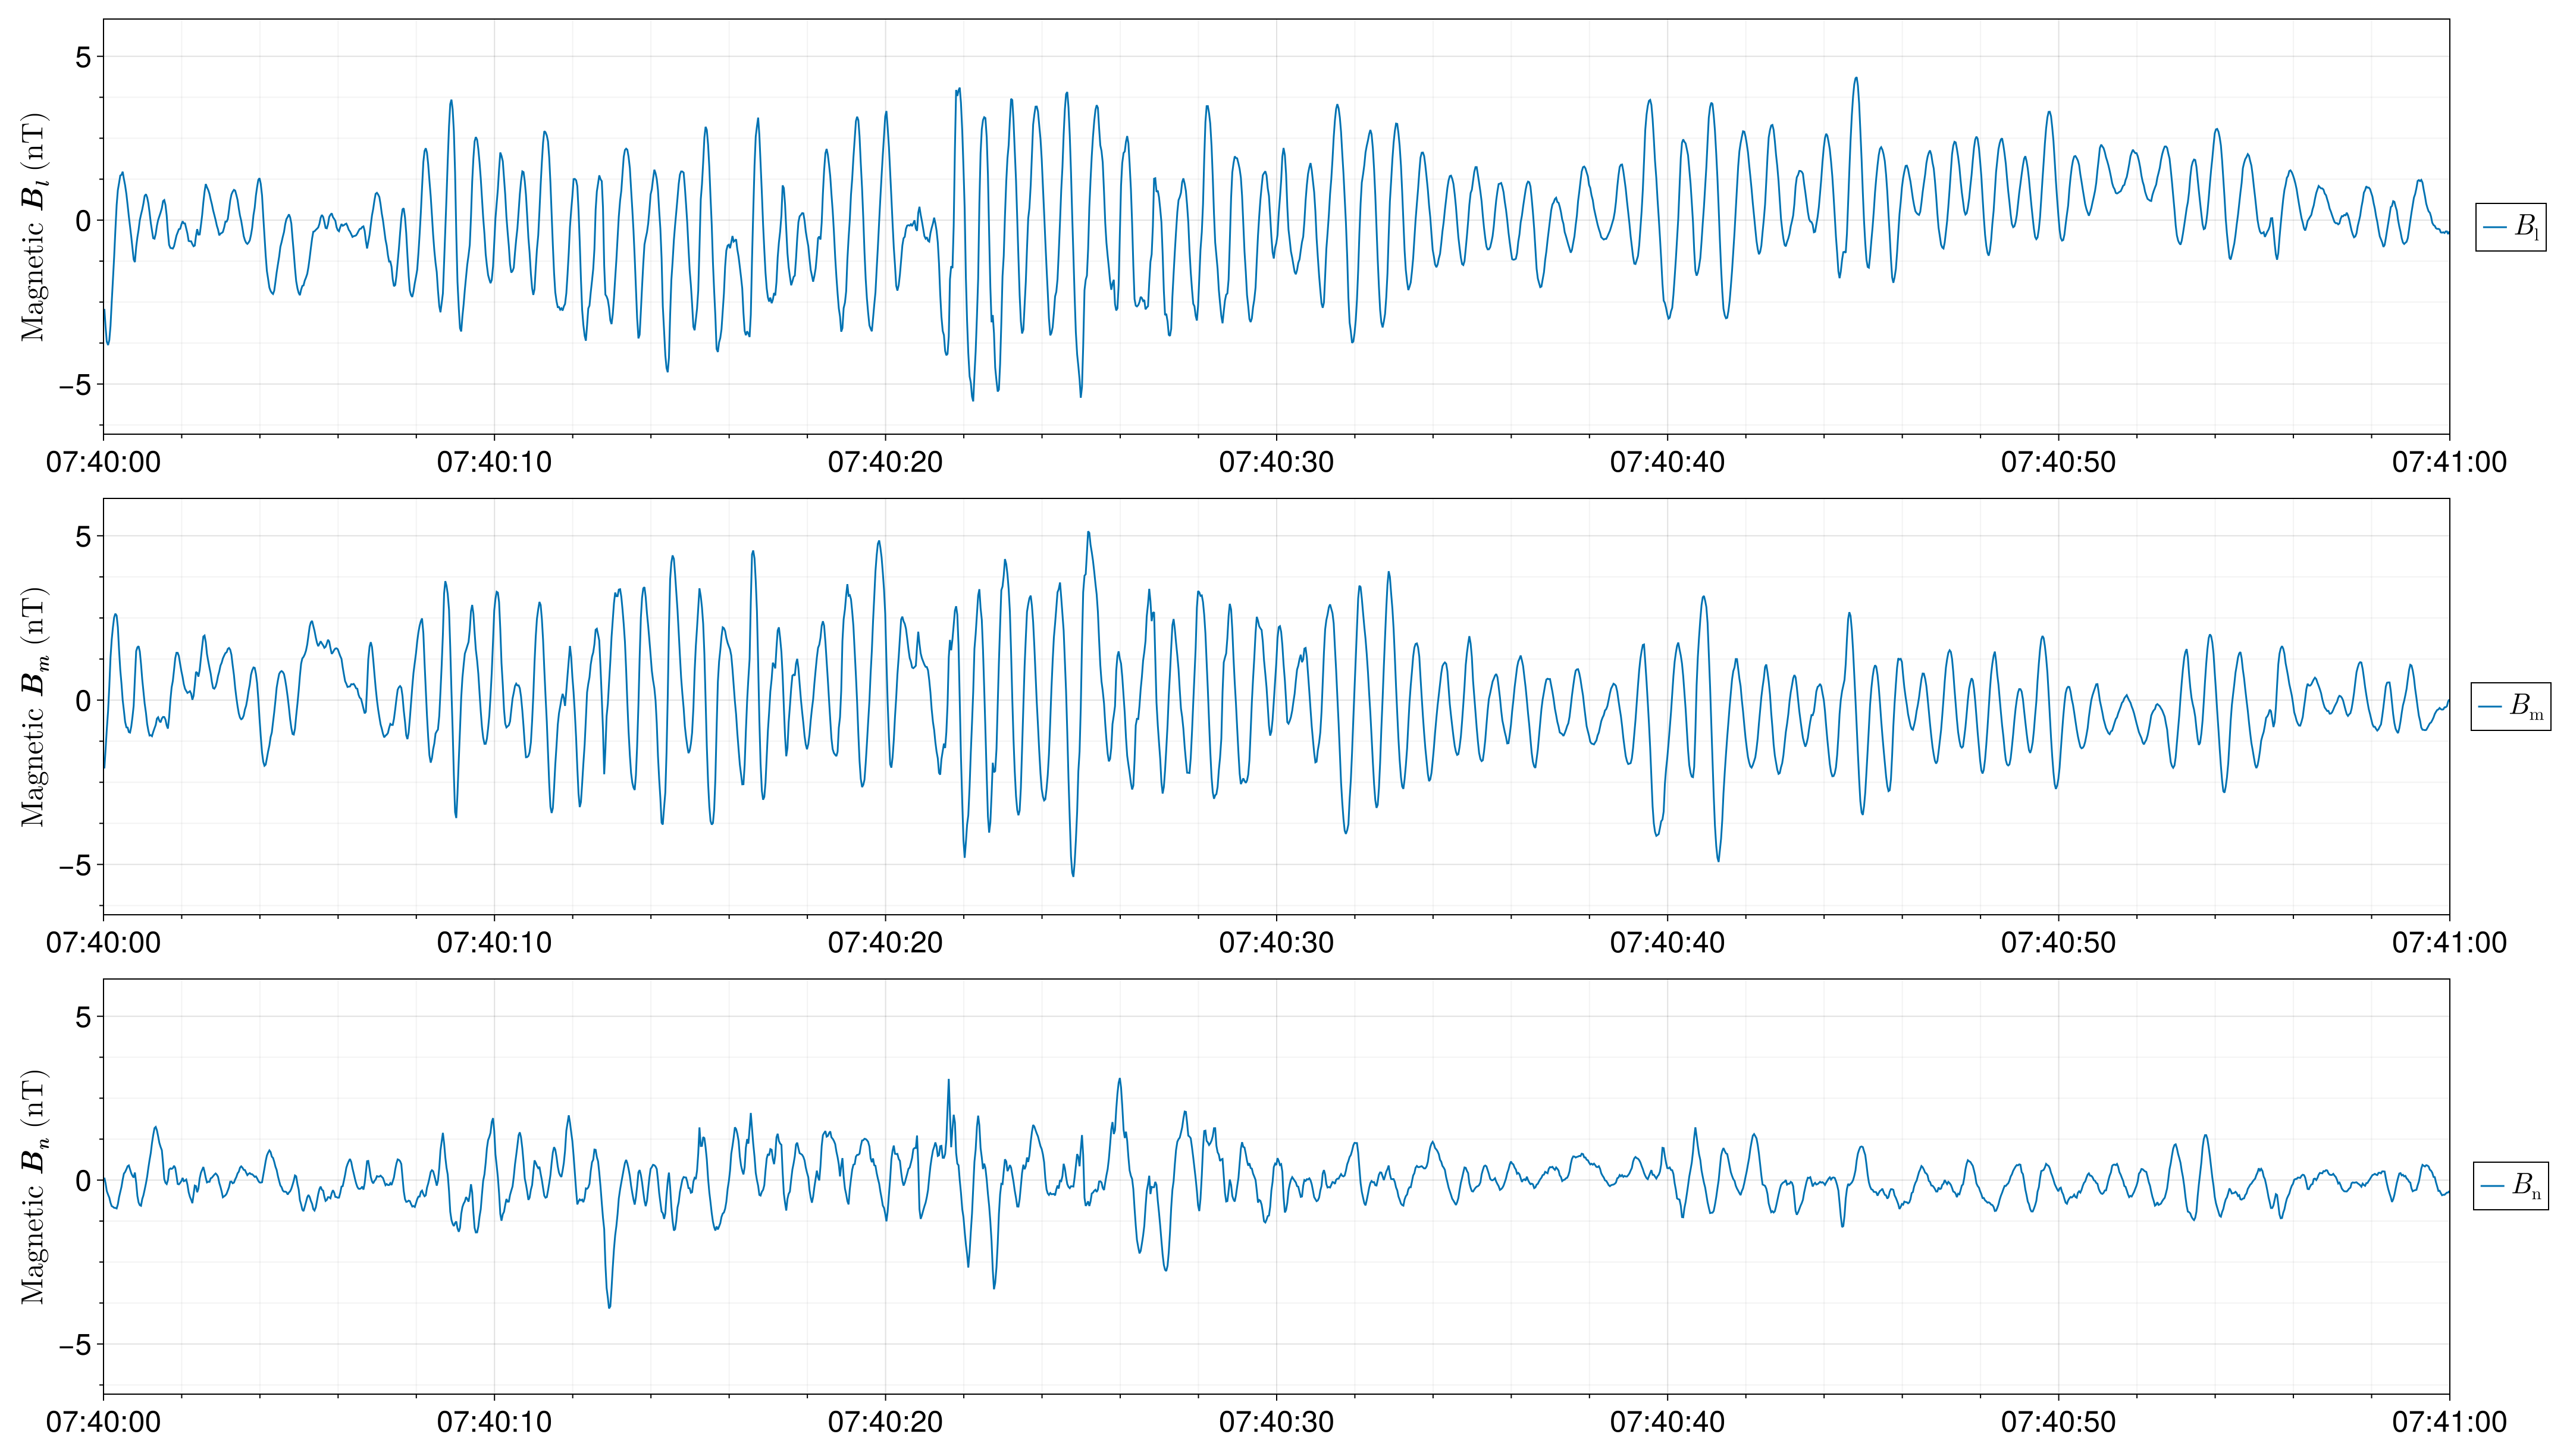

CairoMakie.Screen{IMAGE}


In [140]:
# MVA坐标系
bm = MVA(bWave)
n_hat = bm.vectors[:, 1]
m_hat = bm.vectors[:, 2]
l_hat = bm.vectors[:, 3]
R = R = [l_hat m_hat n_hat]

bWaveMVA = bWave * R

#overview
using CairoMakie, GeometryBasics
CairoMakie.activate!()
println("Drawing...")

size_inches = (30, 17)
size_pt = 72 .* size_inches
fig_MVA = Figure(size = size_pt, fontsize = 25, font = "Times New Roman")

xtk = datetime2julian.(timeWave)
xtk = Float32.(xtk .- mag2c32hz[1, :JulUT])

ax1 = Axis(fig_MVA[1,1:4], ylabel = L"Magnetic $\mathbf{B_l}$ (nT)",
    xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(5), 
    yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4))
ax1.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
xlims!(ax1, minimum(xtk), maximum(xtk))
ylims!(ax1, minimum(bWaveMVA[:, 1:3])-1.0, maximum(bWaveMVA[:, 1:3])+1.0)

ax2 = Axis(fig_MVA[2,1:4], ylabel = L"Magnetic $\mathbf{B_m}$ (nT)",
    xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(5), 
    yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4))
ax2.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
xlims!(ax2, minimum(xtk), maximum(xtk))
ylims!(ax2, minimum(bWaveMVA[:, 1:3])-1.0, maximum(bWaveMVA[:, 1:3])+1.0)

ax3 = Axis(fig_MVA[3,1:4], ylabel = L"Magnetic $\mathbf{B_n}$ (nT)",
    xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(5), 
    yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4))
ax3.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
xlims!(ax3, minimum(xtk), maximum(xtk))
ylims!(ax3, minimum(bWaveMVA[:, 1:3])-1.0, maximum(bWaveMVA[:, 1:3])+1.0)

lines!(ax1, mag2c32hz[indWave, :JulUT].-mag2c32hz[1, :JulUT], bWaveMVA[:, 1], label = L"$B_{\mathrm{l}}$", 
    overdraw = true, linewidth=1.5)
lines!(ax2, mag2c32hz[indWave, :JulUT].-mag2c32hz[1, :JulUT], bWaveMVA[:, 2], label = L"$B_{\mathrm{m}}$", 
    overdraw = true, linewidth=1.5)
lines!(ax3, mag2c32hz[indWave, :JulUT].-mag2c32hz[1, :JulUT], bWaveMVA[:, 3], label = L"$B_{\mathrm{n}}$", 
    overdraw = true, linewidth=1.5)
Legend(fig_MVA[1,5], ax1)
Legend(fig_MVA[2,5], ax2)
Legend(fig_MVA[3,5], ax3)

display(fig_MVA)

In [141]:
save("./MVA_overview_wave.png", fig_MVA)

In [100]:
bmSolar.values

3-element Vector{Float64}:
 0.36914272861046815
 0.667793874136426
 1.3135046386530915

In [88]:
test = angle_between(magSolarMean, kSolar)

134.63445099171417

In [90]:
ShockAngle = angle_between(magSolarMean, kShock)

83.3904918372485

In [49]:
kShock

3-element Vector{Float64}:
  0.021936560737613964
 -0.787245821057258
 -0.6162489793345614

In [340]:
# 记录数据
df = DataFrame(
    DateTime=timeWave[begin],
    Duration=ds*6,
    Amplitude=round(Amplitude,digits = 3),
    Frequence=round(freq.maxFreq,digits = 3),
    PolarDir=handedness,
    PolarAngle=round(rad2deg(phase),digits = 3),
    ProAngle=round(ProAngle,digits = 3), 
    ShockAngle=round(ShockAngle,digits = 3),
    Fx=round(freq.dominant[1],digits = 3),
    Fy=round(freq.dominant[2],digits = 3),
    Fz=round(freq.dominant[3],digits = 3),
    magback=round(magback,digits = 3),
    maxAmplitude=round(maxAm,digits = 3)
)
CSV.write("E:/Acode/JuliaCode/Tianwen/Picture/1Hz Waves.csv", df, append=true, header=false)

"E:/Acode/JuliaCode/Tianwen/Picture/1Hz Waves.csv"

In [27]:
# 截取特定时间数据
titles = Dates.format.(date, "yyyy-mm-dd") * " " * Dates.format.(timeWave[1], "HH:MM:SS") * "-" * 
    Dates.format.(timeWave[end], "HH:MM:SS") * "    " * "Martian 1Hz Waves"
# println(time)

using Statistics

#ind = findall(x-> x<=maximum(time)  && x>=minimum(time), mag2c32hz[!, :Time])
ind = findall(
    (minimum(timeWave) .<= mag2c32hz.Time .<= maximum(timeWave)) .&
    .!isnan.(mag2c32hz.X_MSO) .&
    .!isnan.(mag2c32hz.Y_MSO) .&
    .!isnan.(mag2c32hz.Z_MSO)
)
ReB = BMSO32hz[ind, [:X_MSO, :Y_MSO, :Z_MSO]]
ReB[:, :MSO] = sqrt.(ReB[:, 1].^2 .+ ReB[:, 2].^2 .+ ReB[:, 3].^2)
#ReB[!, :X_MSO] = ReB[!, :X_MSO] .- round(Int, mean(ReB[!, :X_MSO]))
#ReB[!, :Y_MSO] = ReB[!, :Y_MSO] .- round(Int, mean(ReB[!, :Y_MSO])) 
#ReB[!, :Z_MSO] = ReB[!, :Z_MSO] .- round(Int, mean(ReB[!, :Z_MSO]))
println("Data processing finished!")

Data processing finished!


In [28]:
#wavelet power
ns32hz = size(ReB)[1]
# dt32hz = 1.0/32.0
dt32hz = 1.0

println("Wavelet power calculation...")
mother = "MORLET"
wave32hz, period32hz, scale32hz, coi32hz = wavelet(reshape(ReB[:, 1], ns32hz), dt32hz; pad=1, mother=mother)
xpower32hz = abs.(wave32hz).^2
wave32hz, period32hz, scale32hz, coi32hz = wavelet(reshape(ReB[:, 2], ns32hz), dt32hz; pad=1, mother=mother)
ypower32hz = abs.(wave32hz).^2
wave32hz, period32hz, scale32hz, coi32hz = wavelet(reshape(ReB[:, 3], ns32hz), dt32hz; pad=1, mother=mother)
zpower32hz = abs.(wave32hz).^2
Bpower32hz =xpower32hz+ypower32hz+zpower32hz
println("Wavelet power calculation finished!")

Wavelet power calculation...
Wavelet power calculation finished!


In [29]:
# 画轨道、波形和功率谱图4

"bow-shock model"
function bowshock(xshock)
    xF = 0.55 # Rm
    ϵ = 1.05
    L = 2.10 # rm
    rSD = 1.58
    temp = (ϵ^2-1.0)*(xshock-xF)^2-2ϵ*L*(xshock-xF)+L^2
    if temp>=0 
        return sqrt(temp)
    else
        return Inf64
    end
end
"magnetopause model"
function magnetopause(xmp)
    rSD = 1.33
	xF = 0.86
	ϵ = 0.92
	L = 0.90
    temp = (ϵ^2-1.0)*(xmp-xF)^2-2ϵ*L*(xmp-xF)+L^2
    if temp>=0 
        return sqrt(temp)
    else
        return Inf64
    end
end

np = 5001
xshock = range(-10, 3, length=np)
ryzshock = bowshock.(xshock)
ind1 = findall(isfinite, ryzshock)
xshock = [xshock[ind1]; reverse(xshock[ind1])]
ryzshock = [ryzshock[ind1]; -reverse(ryzshock[ind1])]
xmp = range(-10, 3, length=np)
ryzmp = magnetopause.(xmp)
ind1 = findall(isfinite, ryzmp)
xmp = [xmp[ind1]; reverse(xmp[ind1])]
ryzmp = [ryzmp[ind1]; -reverse(ryzmp[ind1])]


#overview
using CairoMakie, GeometryBasics
CairoMakie.activate!()
println("Drawing...")
# light_latexfonts = merge(theme_minimal(), theme_latexfonts())
# set_theme!(light_latexfonts)

size_inches = (30, 17)
size_pt = 72 .* size_inches
fig = Figure(size = size_pt, fontsize = 25, font = "Times New Roman")
#fig = Figure(resolution = (1200, 800), font = "Times New Roman", fontsize = 20)
xtk = datetime2julian.(timeWave)
xtk = Float32.(xtk .- mag2c32hz[1, :JulUT])

ax3 = Axis(fig[1,1], aspect=DataAspect(), xlabel=L"$x$ ($R_{\mathrm{M}}$)", 
    ylabel=L"$\sqrt{y^2+z^2}$ ($R_{\mathrm{M}}$)", xticks=range(-10, 10), yticks=range(-10, 10))
xlims!(ax3, 5, -5) 
ylims!(ax3, 0, 5) 
a1 = arc!(ax3, Point2f(0), 1, 0, π; color=:black, linewidth=2)
phi = range(0, 0.5π; length=180)
x = [cos.(phi); 0.0]
y = [sin.(phi); 0.0]
pn = Polygon(Point2f[(xi, yi) for (xi, yi) in zip(x, y)])
poly!(ax3, pn)

l1 = lines!(ax3, xshock, ryzshock; linewidth=2, overdraw = true)
l2 = lines!(ax3, xmp, ryzmp; linewidth=2, overdraw = true)
l3 = lines!(ax3, mag2c32hz[!, :Probe_Position_X_MSO], 
    sqrt.(mag2c32hz[!, :Probe_Position_Y_MSO].^2+mag2c32hz[!, :Probe_Position_Z_MSO].^2); 
    color=:black, overdraw = true)

indd = findall(x-> x<timeWave[1] + Dates.Second(1)  && x>timeWave[1] - Dates.Second(1), mag2c32hz[!, :Time]) 
str = Dates.format(date, "HH:MM:SS")
scatter!(ax3, mag2c32hz[indd, :Probe_Position_X_MSO], 
    sqrt.(mag2c32hz[indd, :Probe_Position_Y_MSO].^2+mag2c32hz[indd, :Probe_Position_Z_MSO].^2), 
    markersize=20, label=str, color=1, colorrange=(1, 7), colormap=:tab10)
text!(ax3, 0.85, 0.9-0.1, text = str, font = :bold, align = (:center, :center), 
    space = :relative, fontsize = 25, color=1, colorrange=(1, 7), colormap=:tab10)

ax = Axis(fig[1,2:4], ylabel = L"Magnetic $\mathbf{B}$ (nT)", title=titles, 
    xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(5), 
    yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4))
ax.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
xlims!(ax, minimum(xtk), maximum(xtk))
ylims!(ax, minimum(ReB[!, 4])-1.0, maximum(ReB[!, 4])+1.0)

lines!(ax, mag2c32hz[ind, :JulUT].-mag2c32hz[1, :JulUT], ReB[!, :MSO], label = L"$B_{\mathrm{sum}}$", 
    overdraw = true, linewidth=1.5, color = :black)
Legend(fig[1,5], ax)

ax1 = Axis(fig[2,1:4], ylabel = L"Magnetic $\mathbf{B}$ (nT)",
    xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(5), 
    yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4))
ax1.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
xlims!(ax1, minimum(xtk), maximum(xtk))
ylims!(ax1, minimum(Matrix(ReB[!, 1:3]))-1.0, maximum(Matrix(ReB[!, 1:3]))+1.0)

lines!(ax1, mag2c32hz[ind, :JulUT].-mag2c32hz[1, :JulUT], ReB[!, :X_MSO], label = L"$B_{\mathrm{x}}$", 
    overdraw = true, linewidth=1.5)
lines!(ax1, mag2c32hz[ind, :JulUT].-mag2c32hz[1, :JulUT], ReB[!, :Y_MSO], label = L"$B_{\mathrm{y}}$", 
    overdraw = true, linewidth=1.5)
lines!(ax1, mag2c32hz[ind, :JulUT].-mag2c32hz[1, :JulUT], ReB[!, :Z_MSO], label = L"$B_{\mathrm{z}}$", 
    overdraw = true, linewidth=1.5)
Legend(fig[2,5], ax1)

ax2 = Axis(fig[3,1:4], xlabel = L"Time(HH:MM:SS)", ylabel = L"Period $T$ (s)",xticks=xtk, yscale=log2)
ax2.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
xlims!(ax2, minimum(xtk), maximum(xtk))
# ylims!(ax2, 1.0/16.0, 128)
ylims!(ax2, 1.0, 16)
ax2.yreversed = true
hp1 = heatmap!(ax2, magut32hz[ind], period32hz, Bpower32hz', 
    colorscale=log10, colormap=:gist_earth, colorrange=(2e-4, 3e2))
tightlimits!(ax2)
cb = Colorbar(fig[3, 5], hp1, label = L"Wavelet Power $P_{\mathrm{B}}$")

println("Drawing finished!")
save("./" * Dates.format(timeWave[1], "yyyymmdd HH-MM-SS") * "-01Hz-OWWP.png", fig)

Drawing...
Drawing finished!


In [23]:
save("./" * Dates.format(timeWave[1], "yyyymmdd HH-MM-SS") * "-OWWP.png", fig)